# Analysis of Battleship Game

## Introduction

This article will try and analyse the game of the [Battleship](https://en.wikipedia.org/wiki/Battleship_(game)) board game. I try come put with a mathematically motivated strategy, inspired by an [article](https://austinrochford.com/posts/2021-09-02-battleship-bayes.html) by Anthony Rochford. I formalise these ideas in my own way, and build upon them to account for the opposing player's strategy.

We first import necassary packages and define some helper function

In [12]:
import numpy as np
import random
random.seed(42)

import seaborn as sns
import matplotlib.pylab as plt

In [13]:

def plot_board(board):
    """Plot a battleship board."""
    plt.title('Battleship board')
    sns.heatmap(board.board, linewidths=0.5, cmap="tab20c", linecolor="black", cbar=False)
    plt.show()

def plot_probability_heatmap(heatmap):
    """Plot a heatmap of the probability of a ship being in each square."""
    plt.title('Probability of ship present on each tile')
    sns.heatmap(heatmap, linewidths=0.5, annot=True, cmap="mako", linecolor="black", cbar=True, vmin=0, vmax=1)
    plt.show()

## Modelling Game

### Mathematical Setup

We first come to the question of modelling the opponents board. First, however, notice that the game lies on a $10 \times 10$ grid. One approach is to model each tile as a seperate random variable. 

$$\text{Definition: } X^{(r,c)} \text{ represents the tile at row r and column c. } X^{(r,c)} = 1 \text{ if that tile is a ship } X^{(r,c)} = 0 \text{ otherwise.}$$

### Programatic Representation

We represent the opponents board as a 2D boolean array, where True means the cell has a ship and False means it doesn't. 

In [14]:
class Board:
    def __init__(self):
        self.board = np.array([[False] * 10] * 10)

    def __str__(self):
        return str(self.board)

    def set_tile(self, row, col, value):
        """Set the value of a tile on the board."""
        self.board[row, col] = value

    def place_ship(self, ship, is_vert, row, col):
        """
        row, col is top left corner of ships
        Returns True if ship was placed successfully and False otherwise
        Assumes row, col in range [0, 9]
        """
        if is_vert:
            # Make sure ship doesn't go off the board
            if row + ship.length > 10:
                return False
            board_slice = self.board[row:row + ship.length, col]
            if np.any(board_slice):
                return False
            self.board[row:row + ship.length, col] = True
        else:
            # Make sure ship doesn't go off the board
            if col + ship.length > 10:
                return False
            board_slice = self.board[row, col:col + ship.length]
            if np.any(board_slice):
                return False
            self.board[row, col:col + ship.length] = True
        return True

    def generate_random_board(self, ships, conditions=None):
        """Generate the board with ships placed randomly, matching the conditions."""

        if conditions is None:
            conditions = []

        valid_conditions = False
        while not valid_conditions:
            # Reset board
            self.board[:, :] = False

            # Sequentially place ships
            for ship in ships:
                placed = False
                while not placed:
                    is_vert = random.choice([True, False])
                    row = random.randint(0, 9)
                    col = random.randint(0, 9)
                    placed = self.place_ship(ship, is_vert, row, col)
            
            valid_conditions = self.check_conditions_satisfied(conditions)

    def check_conditions_satisfied(self, conditions):
        """Check if all conditions are satisfied."""
        for row, col, value in conditions:
            if self.board[row, col] != value:
                return False
        return True
            

We then have 5 types of ships: Carried, Battleship, Cruiser, Submarine and Destroyer. These have length 5, 4, 3, 3 and 2 respectively. 

In [15]:
class Ship:
    def __init__(self, name, length):
        self.name = name
        self.length = length
        
ships = [Ship("Carrier", 5), Ship("Battleship", 4), Ship("Cruiser", 3), Ship("Submarine", 3), Ship("Destroyer", 2)]

We can now initialise a new board and place a ship

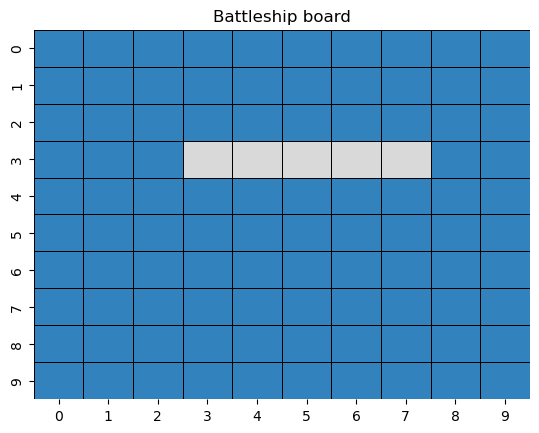

In [16]:
test_board = Board()

# Lets place the Carrier at row 3, col 3
test_board.place_ship(ships[0], False, 3, 3)
plot_board(test_board)

Lets try randomly placing all our ships now

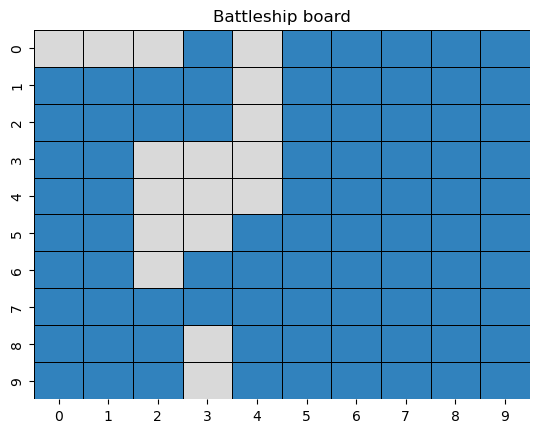

In [17]:
test_board.generate_random_board(ships) # note this function resets the board
plot_board(test_board)

## Computing the Probabilities

### Mathematical Setup

Notice that $X^{(r, c)} \sim Ber(\theta^{(r, c)})$. Hence, $P(X^{(r,c)} = 1) = \theta^{(r, c)}$ is the probability that tile (r, c) has a boat.

Also, we make no i.i.d assumptions for $X^{(r,c)}$ variables. Since, for example, if we know tile (r, c) has a ship, then we can conclude that adjacent tiles are more likely to be ships as well. In fact, this conditioning on known variables will guide our strategy.

Now, we need to find the values of $P(X^{(r,c)} = 1) = \theta^{(r,c)}$: the probability that the (r, c) tile contains a ship. We know that $X^{(r,c)} \sim Ber(\theta^{{(r,c)}})$. Hence, our maximum likelyhood estimator gives us:
$$P(X^{(r,c)} = 1) \approx \theta^{(r, c)}_{MLE} = \frac{1}{n} \sum_{i=1}^{n} x^{(r,c)}_i$$ 

where $x_i^{(r,c)}$ is our $i^{\text{th}}$ observation for the (r,c) tile from our monete carol. $n$ is the number of trails we do. 

### Programatic Representation

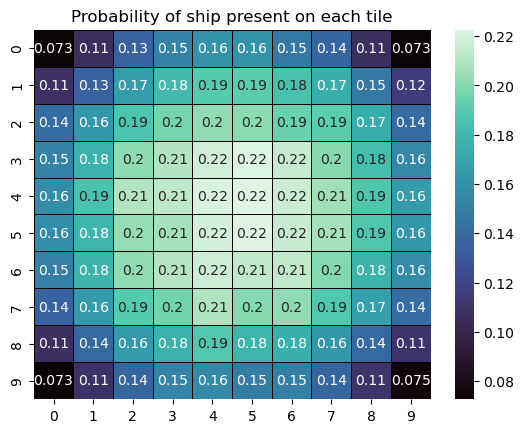

In [18]:
def generate_heatmap(number_of_trials, ships, conditions=None):
    """Generate a heatmap of the probability of a ship being in each square."""
    ship_count_heatmap = np.array([[0] * 10] * 10)
    board = Board()
    for _ in range(n):
        board.generate_random_board(ships, conditions)
        ship_count_heatmap += board.board
    probability_heatmap = ship_count_heatmap / number_of_trials
    return probability_heatmap

n = 10**4
probability_heatmap = generate_heatmap(n, ships)
plot_probability_heatmap(probability_heatmap)


This makes sense. The centre tiles are much more likely to contain ships since there are many ways we can arrage ships in the centre, whereas there fewer ways near the borders. 

Now, what happends to these probabilities when we shoot at a tile? One way to approach this is by conditioning on the result. For example, lets assume we shoot the tile with row index 4 and column index 4. On no, we missed! Therefore, we now need to find $ P(X^{(r,c)} = 1 | X^{(4,4)} = 1) $. As before $ X^{(r,c)} | X^{(4, 4)} = 1 $ follows a bernouli distribution. Hence we can using our maximum likelyhood aproximator again to get:

$$P(X^{(r,c)} = 1 | X^{(4,4)} = 1) \approx \frac{1}{n} \sum_{i=1}^{n} x^{(r,c)}_i$$

$$\text{Subject to: } x^{(4,4)}_i = 1$$

An example board meeting this constraint is shown below. 

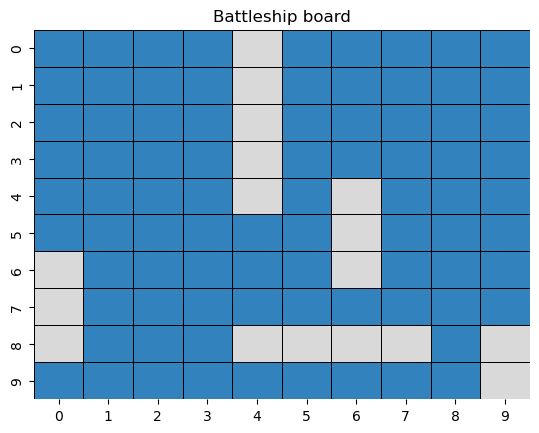

In [19]:
board = Board()

conditions = [(4, 4, True)]
board.generate_random_board(ships, conditions)
plot_board(board)


We now run run a similair montecarlo to the one above, but now with our constaint that $ x^{(4,4)}_i = 1$.

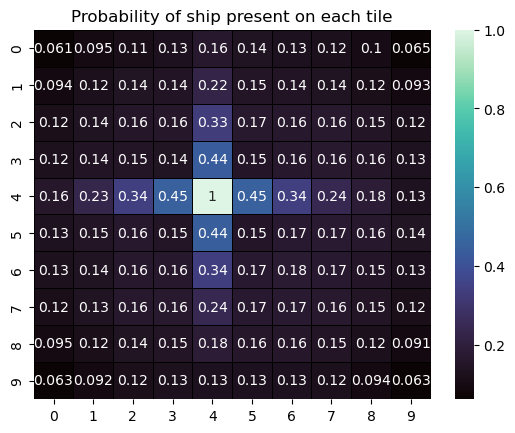

In [20]:
n = 10**4

conditions = [(4, 4, True)]
probability_heatmap = generate_heatmap(n, ships, conditions)
plot_probability_heatmap(probability_heatmap)

This approach works for an arbitraty amount of conditions since we know that the random variable $X^{(r,c)} | C$ follows a bernoulli distibution for any set of conditions $C$.

For example, lets imaging we shoot tile (4, 4), (5, 5) and (3, 6) and miss all. Then the probability of each tile containing a ship would be as follows.

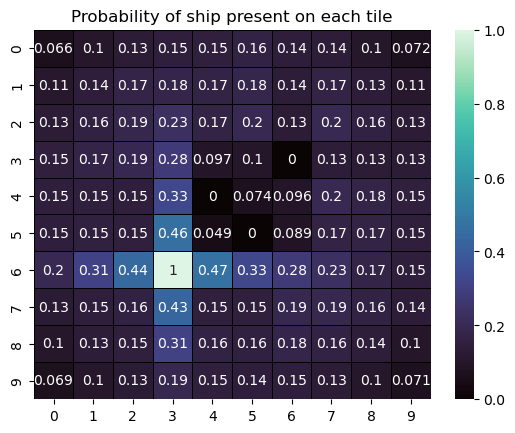

In [21]:
n = 10**4

conditions = [(4, 4, False), (5, 5, False), (3, 6, False), (6, 3, True)]
probability_heatmap = generate_heatmap(n, ships, conditions)
plot_probability_heatmap(probability_heatmap)

We have dealt with hits and misses; however, we have not yet considered the sinking of ships. When we hit all tiles of a opposing player's ship, the opposing player must annouce which ship we have sunk. Let's try considering this information in our model.

Abusing notation slightly, we can write the probability of a tile being a hit as given our knowlege of our previous turns and knowing which ships we sunk as:
$$P(X^{(r,c)} = 1 | X^{(r_0,c_0)} = i_0, ...,X^{(r_n,c_n)} = i_n, C)$$

where $C$ is the set of ship we have sunk so far. 

Now, suppose we have sunk the carrier

## Modelling Performance

todo

In [23]:
# E[T]

## Strategy

We must not that we have made one, rather sever assumtions. That the opposing player places their ships randomly. However, for now lets assume this is true, and then we'll see how we can adapt to different placement distributions.

We have a probability at each stage of the game. Hence, we must find a way to choose a tile based on those. An obvious way would be to choose tile with the maximum probability. Another might be to choose a tile randomly but weighted based on each respective probability. A justification for the second seems less intuitive. But variance... blah... blah... 